In [ ]:
from collections import OrderedDict
import copy
from google.colab import drive
from IPython.display import display
import matplotlib
matplotlib.rcParams['figure.figsize'] = [4, 3]
matplotlib.rcParams['font.size'] = 8
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch import log, manual_seed, nn, ones_like, optim, pow, tensor
from torch.autograd import grad, Variable
from torch.nn.functional import softmax
from torch.utils.data import DataLoader, Dataset

In [ ]:
!pip install pylogit

**Note:** The `pylogit` library needs to be installed manually for Colab. To solve the error `cannot import name 'Iterable' from 'collections' (/usr/lib/python3.10/collections/__init__.py)`, we can replace `collections` with `collections.abc` in the file `/usr/local/lib/python3.10/dist-packages/pylogit/choice_tools.py`.

In [ ]:
import pylogit as pl

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# CMAP Dataset

## Data import

In [ ]:
size = 10000
var, alt = 'auto_cost', 0
data1 = pd.read_csv('/content/drive/My Drive/CMAP/data.csv', index_col=0).sample(size, random_state=0).sort_values(by=var)
data1['mode_imputed'] = data1['mode_imputed'].add(-1)

In [ ]:
data = pd.DataFrame(StandardScaler().fit_transform(data1), columns=data1.columns, index=data1.index)
data['mode_imputed'] = data1['mode_imputed']

In [ ]:
train_size = int(size*.7)
data_train, data_test = data[:train_size], data[train_size:]

## Data processing
2. Build a dataframe with mean values, except for the visualized variable,
3. Build a dataframe with the same size for model regularity calculation, and
4. Load the data for training and testing.

In [ ]:
upper, lower = data[var].max(), data[var].min()
data_prb = pd.DataFrame(np.zeros((51, len(data.columns))), columns=data.columns)
data_prb[var] = np.linspace(lower, upper, len(data_prb))

In [ ]:
data_reg = data_test.copy()
data_reg = data_reg.loc[data_reg.index.repeat(2)]
num_var = data_reg.columns.get_loc(var)
data_reg.iloc[np.arange(1, len(data_reg), 2), num_var] += (upper - lower) / 50

In [ ]:
class Load_data(Dataset):
    'Class to load the training, testing, and plotting sets'
    def __init__(self, data):
        x_set = data.drop(columns='mode_imputed')
        y_set = data['mode_imputed']
        self.X = Variable(tensor(x_set.values).float(), requires_grad=True)
        self.y = tensor(y_set.values)
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    def __len__(self):
        return len(self.X)

train_loader = DataLoader(Load_data(data_train), batch_size=size//10, shuffle=True)
test_loader = DataLoader(Load_data(data_test), batch_size=len(data_test))

# Datasets for model analysis
share_loader = DataLoader(Load_data(data_train), batch_size=train_size)
prb_loader = DataLoader(Load_data(data_prb), batch_size=len(data_prb))
reg_loader = DataLoader(Load_data(data_reg), batch_size=len(data_reg))

## True market shares

In [ ]:
ls_alt = ['Auto', 'Train', 'Active']

def true_share(df):
    'Function to calculate the true market shares'
    y = df['mode_imputed'].replace(0, ls_alt[0]).replace(1, ls_alt[1]).replace(2, ls_alt[2])
    return y.value_counts(normalize=True)

In [ ]:
# Training set
true_share(data_train)

Auto      0.665571
Active    0.251429
Train     0.083000
Name: mode_imputed, dtype: float64

In [ ]:
# Testing set
true_share(data_test)

Auto      0.783
Train     0.140
Active    0.077
Name: mode_imputed, dtype: float64

# Multinomial Logit (MNL)

## Data processing
The MNL model is estimated based on unstandardized inputs and a data frame with wide format.

In [ ]:
def convert(df):
    'Function for data format conversion'
    df = df.reset_index(names='obs_id', drop=True)
    for a in ['auto', 'train', 'active']:
        df[f'ava_{a}'] = 1
    # Individual-specific variables
    ind_vars = df.columns.tolist()[:4]
    # Alternative-specific variables
    alt_vars = {u'time': dict([(0, 'auto_time'), (1, 'train_time'), (2, 'active_time')]),
                u'cost': dict([(0, 'auto_cost'), (1, 'train_cost')])}
    # Availability variables
    ava_vars = {0: 'ava_auto', 1: 'ava_train', 2: 'ava_active'}
    # Observation ID column
    df['obs_id'] = np.arange(df.shape[0], dtype=int) + 1
    # Wide format -> long format
    df_lg = pl.convert_wide_to_long(df, ind_vars, alt_vars, ava_vars, 'obs_id', 'mode_imputed', 'alt_id')
    return df_lg

In [ ]:
data1_train, data1_test = data1[:train_size], data1[train_size:]
data1_train_lg = convert(data1_train)
data1_train_lg

,obs_id,alt_id,mode_imputed,sex,inc,age,veh,time,cost
0,1,0,1,0,0,24,1,15.916667,1.2380
1,1,1,0,0,0,24,1,43.633333,2.3800
2,1,2,0,0,0,24,1,63.483333,0.0000
3,2,0,1,1,1,45,1,9.483333,1.2530
4,2,1,0,1,1,45,1,78.300000,2.5150
...,...,...,...,...,...,...,...,...,...
20995,6999,1,0,1,1,43,1,79.900000,2.3700
20996,6999,2,0,1,1,43,1,70.650000,0.0000
20997,7000,0,1,0,0,55,1,14.000000,8.8038
20998,7000,1,0,0,0,55,1,80.583333,2.3300


## Model structure
The deterministic utilities are specified as follows:

\begin{align}
    V_{n1} &= w_{\mathrm{time},1} \mathrm{time}_{nc} + w_{\mathrm{cost},1} \mathrm{cost}_{n1} \\
    V_{n2} &= w_{0,2} + w_{\mathrm{sex},2} \mathrm{sex}_n + w_{\mathrm{inc},2} \mathrm{inc}_n + w_{\mathrm{age},2} \mathrm{age}_n + w_{\mathrm{veh},2} \mathrm{veh}_n + w_{\mathrm{time},2} \mathrm{time}_{n2} + w_{\mathrm{cost},2} \mathrm{cost}_{n2} \\
    V_{n3} &= w_{0,3} + w_{\mathrm{sex},3} \mathrm{sex}_n + w_{\mathrm{inc},3} \mathrm{inc}_n + w_{\mathrm{age},3} \mathrm{age}_n + w_{\mathrm{veh},3} \mathrm{veh}_n + w_{\mathrm{time},3} \mathrm{time}_{n3}
\end{align}

where subscripts 1-3 represent automobile, train, and the active mode, respectively.

In [ ]:
spec = OrderedDict()
name = OrderedDict()

# Alternative-specific constants
spec['intercept'] = [1, 2]
name['intercept'] = ['asc_train', 'asc_active']

# Individual-specific variables
spec['sex'] = [1, 2]
name['sex'] = ['sex_train', 'sex_active']
spec['inc'] = [1, 2]
name['inc'] = ['inc_train', 'inc_active']
spec['age'] = [1, 2]
name['age'] = ['age_train', 'age_active']
spec['veh'] = [1, 2]
name['veh'] = ['veh_train', 'veh_active']

# Alternative-specific variables
spec['time'] = [0, 1, 2]
name['time'] = ['time_auto', 'time_train', 'time_active']
spec['cost'] = [0, 1]
name['cost'] = ['cost_auto', 'cost_train']

## Parameter estimation

In [ ]:
mnl = pl.create_choice_model(data1_train_lg, alt_id_col='alt_id', obs_id_col='obs_id', choice_col='mode_imputed',
                             specification=spec, model_type='MNL', names=name)
mnl.fit_mle(np.zeros(15))
mnl.get_statsmodels_summary()

Log-likelihood at zero: -7,690.2860
Initial Log-likelihood: -7,690.2860
Estimation Time for Point Estimation: 0.18 seconds.
Final log-likelihood: -4,811.7822


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:554: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                mode_imputed   No. Observations:                7,000
Model:             Multinomial Logit Model   Df Residuals:                    6,985
Method:                                MLE   Df Model:                           15
Date:                     Wed, 12 Jul 2023   Pseudo R-squ.:                   0.374
Time:                             12:48:49   Pseudo R-bar-squ.:               0.372
AIC:                             9,653.564   Log-Likelihood:             -4,811.782
BIC:                             9,756.369   LL-Null:                    -7,690.286
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
asc_train      -2.7295      0.814     -3.354      0.001      -4.324      -1.135
asc_active     -1.8782      0.401     -4.686      0.000      -2.664      -1.093
sex_train       0.5960      0.095      6.270      0.000       0.410       0.782
sex_active      0.4189      0.063      6.652      0.000       0.295       0.542
inc_train       0.4235      0.104      4.089      0.000       0.221       0.627
inc_active      0.4948      0.069      7.166      0.000       0.359       0.630
age_train      -0.0127      0.004     -3.176      0.001      -0.021      -0.005
age_active     -0.0117      0.003     -4.639      0.000      -0.017      -0.007
veh_train      -0.6141      0.063     -9.772      0.000      -0.737      -0.491
veh_active     -0.7486      0.041    -18.229      0.000      -0.829      -0.668
time_auto      -0.1539      0.010    -15.300      0.000      -0.174      -0.134
time_train     -0.0520      0.004    -12.674      0.000      -0.060      -0.044
time_active    -0.0805      0.003    -28.309      0.000      -0.086      -0.075
cost_auto      -0.3711      0.057     -6.459      0.000      -0.484      -0.259
cost_train     -0.5462      0.297     -1.840      0.066      -1.128       0.036
===============================================================================
"""

## Results

In [ ]:
def mnl_share(df):
    'Function to calculate the MNL market shares'
    pop = len(df)//3
    X = df.drop(columns='mode_imputed')
    prb = sum(mnl.predict(X).reshape(pop, 3)) / pop
    share = pd.DataFrame(prb*100, columns=['Share']).round(decimals=1).astype(str).add('%')
    share.insert(0, 'Mode', ls_alt)
    return share

In [ ]:
# Training set
mnl_share(data1_train_lg)

,Mode,Share
0,Auto,66.6%
1,Train,8.3%
2,Active,25.1%


In [ ]:
# Testing set
data1_test_lg = convert(data1_test)
mnl_share(data1_test_lg)

,Mode,Share
0,Auto,64.5%
1,Train,33.6%
2,Active,2.0%


In [ ]:
prb = mnl.predict(data1_test_lg).reshape(len(data1_test_lg)//3, 3)
y_test = data_test['mode_imputed']
acc = (prb.argmax(1) == y_test).sum() / len(y_test)
print(f'Test accuracy = {acc*100:.1f}%')

Test accuracy = 69.6%


In [ ]:
ll = 0
for i in range(len(data1_test_lg)//3):
    ll += np.log(prb[i, y_test.iloc[i]])
print(f'Test log-likelihood = {ll:.1f}')

Test log-likelihood = -3268.0


In [ ]:
# Plot the histogram of test accuracies
# plt.hist(acc, bins=25, range=(.4, .9), color='mediumblue')
# plt.gca().yaxis.set_major_formatter(PercentFormatter(1, 0))
# plt.xlabel('Test accuracy')
# plt.ylabel('Percentage of all trials')
# plt.show()

In [ ]:
upper1, lower1 = data1[var].max(), data1[var].min()
data1_prb = pd.DataFrame(np.tile(data1.mean(), (51, 1)), columns=data1.columns)
data1_prb['mode_imputed'] = pd.Series([np.random.randint(0, 3) for i in range(len(data1_prb))])
data1_prb[var] = np.linspace(lower1, upper1, len(data1_prb))

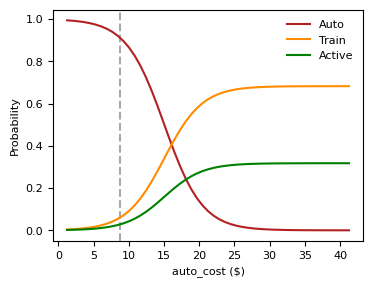

In [ ]:
data1_prb_lg = convert(data1_prb)
ls1_prb = mnl.predict(data1_prb_lg).reshape(len(data1_prb_lg)//3, 3)
ls1_grd = mnl.params[11] * ls1_prb[:, alt] * (1-ls1_prb[:, alt])

# Plot probabilities
# plt.plot(data1_prb[var], ls1_prb[:, alt], color='dimgrey')
# plt.xlabel(f'{var}')
# plt.ylabel('Probability')
# plt.show()

# Plot probability derivatives
# plt.plot(data1_prb[var], ls1_grd, color='dimgrey')
# plt.xlabel(f'{var}')
# plt.ylabel('Probability derivative')
# plt.show()

# Plot substitution patterns
ls_color = ['firebrick', 'darkorange', 'green', 'mediumblue']
plt.axvline(data1.iloc[train_size, num_var], ls='--', color='darkgray')
for a in range(3):
    plt.plot(data1_prb[var], ls1_prb[:, a], color=ls_color[a], label=ls_alt[a])
plt.legend(frameon=False)
plt.xlabel(f'{var} ($)')
plt.ylabel('Probability')
plt.show()

In [ ]:
data1_reg = data1_test.copy()
data1_reg = data1_reg.loc[data1_reg.index.repeat(2)]
data1_reg.iloc[np.arange(1, len(data1_reg), 2), num_var] += (upper1 - lower1) / 50

data1_reg_lg = convert(data1_reg)
ls1_reg = mnl.predict(data1_reg_lg).reshape(len(data1_reg_lg)//3, 3)[:, alt]

In [ ]:
def cal_reg(ls_reg):
    eps = 1e-4
    diff = np.subtract(ls_reg[::2], ls_reg[1::2])
    diff_st = [(d > eps).astype(int) for d in diff]
    diff_wk = [(d > -eps).astype(int) for d in diff]
    reg_st = sum(diff_st) / len(diff_st)
    reg_wk = sum(diff_wk) / len(diff_wk)
    print(f'Strong regularity = {reg_st:.4f}')
    print(f'Weak regularity = {reg_wk:.4f}')
    return reg_st, reg_wk

In [1]:
# reg_st, reg_wk = cal_reg(ls1_reg)

# Deep neural network (DNN)

## Model structure

In [ ]:
class DNN(nn.Module):
    'Class of DNNs'
    def __init__(self):
        super(DNN, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(9, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 3)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)

## Model training
We train each model 30 times and take the average results of 10 models for analysis.

In [ ]:
def cal_loss(model, X, y, regularizer, sum, lambd, criterion):
    'Function to regularize the loss function'
    'lambd is the weight of regularizer -> (1-lambd) is the weight of loss'
    'sum is an indicator of regularizing summation'
    loss = criterion(model(X), y)
    # Utility gradient regularizer
    if regularizer == 'util':
        utl = model(X)
        g_c = grad(utl[:, 0], X, ones_like(utl[:, 0]), create_graph=True)[0][:, 4:6]
        g_t = grad(utl[:, 1], X, ones_like(utl[:, 1]), create_graph=True)[0][:, 6:8]
        g_a = grad(utl[:, 2], X, ones_like(utl[:, 2]), create_graph=True)[0][:, 8]
    # Probability gradient regularizer
    elif regularizer == 'prob':
        prb = softmax(model(X), dim=1)
        g_c = grad(prb[:, 0], X, ones_like(prb[:, 0]), create_graph=True)[0][:, 4:6]
        g_t = grad(prb[:, 1], X, ones_like(prb[:, 1]), create_graph=True)[0][:, 6:8]
        g_a = grad(prb[:, 2], X, ones_like(prb[:, 2]), create_graph=True)[0][:, 8]
    # Loss gradient regularizer
    elif regularizer == 'loss':
        log_prb = log(softmax(model(X), dim=1))
        g_c = grad(log_prb[:, 0]*(y==0), X, ones_like(log_prb[:, 0]), create_graph=True)[0][:, 4:6]
        g_t = grad(log_prb[:, 1]*(y==1), X, ones_like(log_prb[:, 0]), create_graph=True)[0][:, 6:8]
        g_a = grad(log_prb[:, 2]*(y==2), X, ones_like(log_prb[:, 0]), create_graph=True)[0][:, 8]
    else:
        return loss
    # Compute the regularizer
    if sum:
        g_c[g_c < 0] = 0
        g_t[g_t < 0] = 0
        g_a[g_a < 0] = 0
        reg = g_c.sum() + g_t.sum() + g_a.sum()
    else:
        reg = pow(g_c, 2).sum() + pow(g_t, 2).sum() + pow(g_a, 2).sum()
    return loss + lambd * reg

In [ ]:
def train_loop(model, regularizer, sum, lambd, optimizer, criterion):
    'Function for DNN training in each epoch'
    for batch, (X, y) in enumerate(train_loader):
        loss = cal_loss(model, X, y, regularizer, sum, lambd, criterion)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
def test(model, criterion):
    'Function for DNN testing'
    # For loss, accuracy, and market share (testing set) calculation
    for X, y in test_loader:
        pred = model(X)
        loss = criterion(pred, y).item()
        cor = (pred.argmax(1) == y).float().sum()
        share_test = softmax(pred, dim=1).detach().numpy()
        p = softmax(pred, dim=1)
    loss /= len(test_loader)
    acc = cor / len(test_loader.dataset)
    # For market share (training set) calculation
    for X, _ in share_loader:
        share_train = softmax(model(X), dim=1).detach().numpy()
    # For probability and gradient calculation
    for X, _ in prb_loader:
        p = softmax(model(X), dim=1)
        prb = p.detach().numpy()
        grd = grad(p[:, alt], X, ones_like(p[:, alt]), create_graph=True)[0][:, num_var].detach().numpy()
    # For regularity calculation
    for X, _ in reg_loader:
        reg = softmax(model(X), dim=1)[:, alt].detach().numpy()
    return loss, acc, share_train, share_test, prb, grd, reg

In [ ]:
def train_DNN(regularizer, sum, lambd):
    'Function for DNN training (10 models * 30 epochs)'
    ls_loss, ls_acc, ls_share_ts, ls_share_tr, ls_prb, ls_grd, ls_reg = [[] for i in range(7)]
    for m in range(10):
        manual_seed(m)
        model = DNN()
        optimizer = optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()
        for i in range(30):
            train_loop(model, regularizer, sum, lambd, optimizer, criterion)
        loss, acc, share_train, share_test, prb, grd, reg = test(model, criterion)
        [x.append(y) for x, y in zip([ls_loss, ls_acc, ls_share_ts, ls_share_tr, ls_prb,
                                      ls_grd], [loss, acc, share_train, share_test, prb, grd])]
        ls_reg.extend(reg)
        print(f'Model {m+1:<2}: {loss:.4f}, {acc*100:.1f}%')
    return ls_loss, ls_acc, ls_share_tr, ls_share_ts, np.array(ls_prb), ls_grd, ls_reg

## Functions for analysis
We evaluate the models by:
- test losses and accuracies,
- strong and weak regularities.

In [ ]:
def dnn_agg(ls_loss, ls_acc):
    'Function to analyze aggregate DNN performance'
    mean_loss, mean_acc = np.mean(ls_loss), np.mean(ls_acc)
    ll = -mean_loss * (size - train_size)
    print(f'Mean test log-likelihood = {ll:.1f}')
    print(f'Mean test accuracy = {mean_acc*100:.1f}%')
    agg_ll, agg_acc = ll, mean_acc
    # Plot the histogram of test accuracies
    # plt.hist(ls_acc, bins=25, range=(.4, .9), weights=np.ones(len(ls_acc))/len(ls_acc), color='mediumblue')
    # plt.gca().yaxis.set_major_formatter(PercentFormatter(1, 0))
    # plt.xlabel('Test accuracy')
    # plt.ylabel('Percentage of all trials')
    # plt.show()
    return agg_ll, agg_acc

In [ ]:
def dnn_share(ls_share):
    'Function to analyze DNN market shares of modes'
    share = [sum(s)/len(s) for s in ls_share]
    avg_share = np.mean(share, 0) * 100
    std_share = np.std(share, 0) * 100
    df_avg = pd.DataFrame(avg_share).round(decimals=1)
    df_std = pd.DataFrame(std_share).round(decimals=1)
    df = df_avg.astype(str).add('% (').add(df_std.astype(str)).add('%)')
    df.columns = ['Share']
    df.insert(0, 'Mode', ls_alt)
    display(df)

In [ ]:
def dnn_sub(ls_prb, ls_grd):
    'Function to analyze DNN prabilities, probability derivatives, and substitution patterns'
    # Plot probabilities
    # for p in ls_prb[:, :, alt]:
    #     plt.plot(data1_prb[var], p, color='dimgrey', alpha=.15)
    # plt.plot(data1_prb[var], np.mean(ls_prb[:, :, alt], axis=0), color='dimgrey')
    # plt.xlabel(f'{var}')
    # plt.ylabel('Probability')
    # plt.show()
    # Plot probability derivatives
    # for p in ls_grd:
    #     plt.plot(data1_prb[var], p, color='dimgrey', alpha=.15)
    # plt.plot(data1_prb[var], np.mean(ls_grd, axis=0), color='dimgrey')
    # plt.xlabel(f'{var}')
    # plt.ylabel('Probability derivative')
    # plt.show()
    # Plot substitution patterns
    plt.axvline(data1.iloc[train_size, num_var], ls='--', color='darkgray')
    for a in range(3):
        for p in ls_prb[:, :, a]:
            plt.plot(data1_prb[var], p, color=ls_color[a], alpha=.15)
        plt.plot(data1_prb[var], np.mean(ls_prb[:, :, a], axis=0), color=ls_color[a], label=ls_alt[a])
    plt.legend(frameon=False)
    plt.xlabel(f'{var} ($)')
    plt.ylabel('Probability')
    plt.show()

In [ ]:
def comparison(lambdas, agg_ll, agg_acc, ls_st, ls_wk):
    'Function to compare DNN models'
    if len(lambdas) == 1:
        return
    print('-'*30, '\nModel comparison:')
    fig, ax1 = plt.subplots()
    # Plot test log-likelihoods
    ax1.grid(linestyle='--', color='lightgray')
    ax1.plot(np.log10(lambdas), agg_ll, marker='x', color=ls_color[0], label='Log-likelihood')
    ax1.set_xlabel(r'$\lg(\lambda)$')
    ax1.set_ylabel('Test log-likelihood')
    # Plot test accuracies
    ax2 = ax1.twinx()
    ax2.plot(np.log10(lambdas), agg_acc, marker='x', color=ls_color[1], label='Accuracy')
    ax2.set_ylabel('Test accuracy & Regularity')
    # Plot regularities
    ax2.plot(np.log10(lambdas), ls_st, linestyle='dashed', marker='x', color=ls_color[2], label='Strong regularity')
    ax2.plot(np.log10(lambdas), ls_wk, linestyle='dashed', marker='x', color=ls_color[3], label='Weak regularity')
    # fig.legend(loc="upper left", bbox_to_anchor=(0, 1), bbox_transform=ax1.transAxes, frameon=False)

In [ ]:
def result(regularizer, lambdas=[0], sum=True):
    'Function to display all DNN results'
    agg_loss, agg_acc, ls_st, ls_wk = [[] for i in range(4)]
    for lambd in lambdas:
        print('Penalty =', lambd)
        # Individual losses and accuracies
        print('-'*30, '\nTest losses and accuracies:')
        ls_loss, ls_acc, ls_share_tr, ls_share_ts, ls_prb, ls_grd, ls_reg = train_DNN(regularizer, sum, lambd)
        # Mean loss and accuracy
        print('-'*30)
        [x.append(y) for x, y in zip([agg_loss, agg_acc], dnn_agg(ls_loss, ls_acc))]
        # Market shares
        print('-'*30, '\nTraining set:')
        dnn_share(ls_share_tr)
        print('-'*30, '\nTesting set:')
        dnn_share(ls_share_ts)
        # Regularities
        print('-'*30)
        reg_st, reg_wk = cal_reg(ls_reg)
        # Substitution patterns
        print('-'*30)
        dnn_sub(ls_prb, ls_grd)
        [x.append(y) for x, y in zip([ls_st, ls_wk], [reg_st, reg_wk])]
    comparison(lambdas, agg_loss, agg_acc, ls_st, ls_wk)

## Results

### Without regularization

Penalty = 0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6357, 78.6%
Model 2 : 0.6752, 78.5%
Model 3 : 0.6194, 78.6%
Model 4 : 0.6127, 78.3%
Model 5 : 0.6212, 78.3%
Model 6 : 0.6025, 77.9%
Model 7 : 0.7154, 78.3%
Model 8 : 0.5861, 78.4%
Model 9 : 0.7053, 78.4%
Model 10: 0.6722, 78.6%
------------------------------
Mean test log-likelihood = -1933.7
Mean test accuracy = 78.4%
------------------------------ 
Training set:


,Mode,Share
0,Auto,84.5% (4.7%)
1,Train,8.4% (2.6%)
2,Active,7.1% (2.2%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,65.9% (1.5%)
1,Train,8.3% (0.4%)
2,Active,25.8% (1.2%)


------------------------------
Strong regularity = 0.5307
Weak regularity = 0.6645
------------------------------


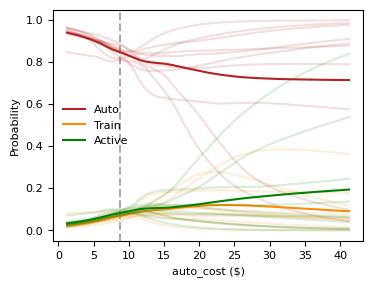

In [ ]:
result('none')

### Utility gradient regularization

Penalty = 100.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7264, 78.3%
Model 2 : 0.6784, 78.4%
Model 3 : 0.7021, 78.3%
Model 4 : 0.6909, 78.3%
Model 5 : 0.6841, 78.3%
Model 6 : 0.7476, 78.3%
Model 7 : 0.6975, 78.3%
Model 8 : 0.7119, 78.3%
Model 9 : 0.6735, 78.3%
Model 10: 0.7208, 78.3%
------------------------------
Mean test log-likelihood = -2109.9
Mean test accuracy = 78.3%
------------------------------ 
Training set:


,Mode,Share
0,Auto,68.3% (4.0%)
1,Train,10.5% (2.2%)
2,Active,21.1% (2.0%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,65.3% (2.0%)
1,Train,10.9% (1.6%)
2,Active,23.8% (0.9%)


------------------------------
Strong regularity = 0.9809
Weak regularity = 0.9864
------------------------------


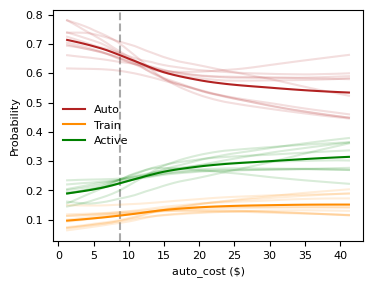

Penalty = 10.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6925, 77.9%
Model 2 : 0.6688, 78.4%
Model 3 : 0.6898, 78.5%
Model 4 : 0.6611, 78.4%
Model 5 : 0.6604, 77.8%
Model 6 : 0.7078, 78.3%
Model 7 : 0.6928, 78.5%
Model 8 : 0.7074, 78.4%
Model 9 : 0.6689, 78.1%
Model 10: 0.7292, 75.5%
------------------------------
Mean test log-likelihood = -2063.6
Mean test accuracy = 78.0%
------------------------------ 
Training set:


,Mode,Share
0,Auto,71.3% (3.8%)
1,Train,8.2% (1.0%)
2,Active,20.5% (2.9%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,66.9% (0.5%)
1,Train,8.1% (0.4%)
2,Active,25.0% (0.7%)


------------------------------
Strong regularity = 0.9872
Weak regularity = 0.9891
------------------------------


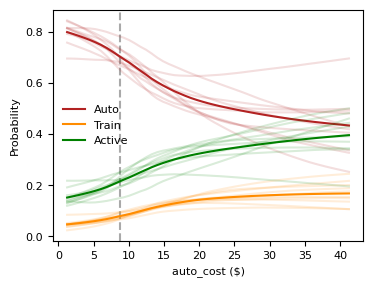

Penalty = 1.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6165, 77.9%
Model 2 : 0.5937, 78.3%
Model 3 : 0.6192, 78.5%
Model 4 : 0.6133, 78.3%
Model 5 : 0.6415, 77.8%
Model 6 : 0.6204, 78.4%
Model 7 : 0.7477, 78.1%
Model 8 : 0.6205, 78.4%
Model 9 : 0.6083, 77.9%
Model 10: 0.6317, 77.8%
------------------------------
Mean test log-likelihood = -1893.8
Mean test accuracy = 78.1%
------------------------------ 
Training set:


,Mode,Share
0,Auto,79.4% (3.9%)
1,Train,9.3% (1.7%)
2,Active,11.3% (2.9%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,66.5% (0.9%)
1,Train,8.0% (0.2%)
2,Active,25.5% (0.9%)


------------------------------
Strong regularity = 0.9700
Weak regularity = 0.9990
------------------------------


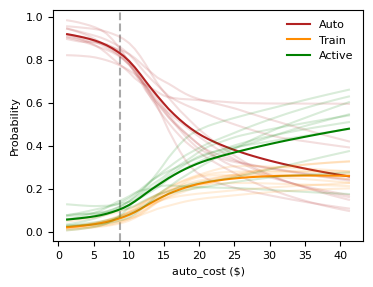

Penalty = 0.1
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6122, 78.3%
Model 2 : 0.5885, 78.4%
Model 3 : 0.6007, 78.1%
Model 4 : 0.6022, 78.0%
Model 5 : 0.6152, 77.3%
Model 6 : 0.6370, 75.1%
Model 7 : 0.6386, 77.7%
Model 8 : 0.5676, 78.5%
Model 9 : 0.6044, 77.9%
Model 10: 0.5796, 78.5%
------------------------------
Mean test log-likelihood = -1813.7
Mean test accuracy = 77.8%
------------------------------ 
Training set:


,Mode,Share
0,Auto,75.7% (3.2%)
1,Train,15.7% (2.1%)
2,Active,8.6% (1.5%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,65.4% (1.2%)
1,Train,8.5% (0.3%)
2,Active,26.1% (1.0%)


------------------------------
Strong regularity = 0.9296
Weak regularity = 0.9959
------------------------------


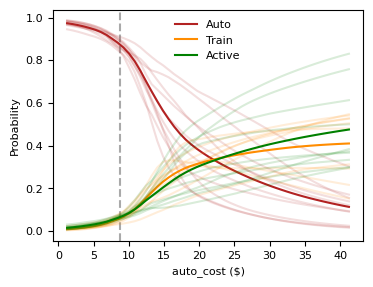

Penalty = 0.01
------------------------------ 
Test losses and accuracies:
Model 1 : 0.5828, 78.6%
Model 2 : 0.6198, 78.8%
Model 3 : 0.5863, 78.4%
Model 4 : 0.6006, 78.4%
Model 5 : 0.6417, 78.6%
Model 6 : 0.6189, 76.5%
Model 7 : 0.6747, 78.3%
Model 8 : 0.5825, 78.7%
Model 9 : 0.6286, 78.6%
Model 10: 0.5850, 78.7%
------------------------------
Mean test log-likelihood = -1836.3
Mean test accuracy = 78.3%
------------------------------ 
Training set:


,Mode,Share
0,Auto,79.7% (4.3%)
1,Train,11.9% (2.7%)
2,Active,8.4% (1.7%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,65.3% (1.3%)
1,Train,8.5% (0.3%)
2,Active,26.2% (1.1%)


------------------------------
Strong regularity = 0.8808
Weak regularity = 0.9724
------------------------------


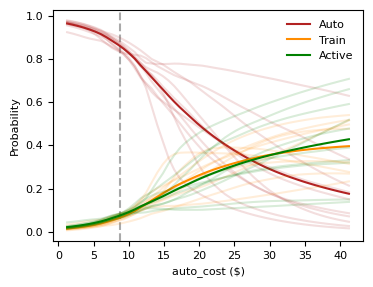

Penalty = 0.001
------------------------------ 
Test losses and accuracies:
Model 1 : 0.5811, 78.4%
Model 2 : 0.6542, 78.5%
Model 3 : 0.5887, 78.8%
Model 4 : 0.5982, 78.3%
Model 5 : 0.6661, 78.4%
Model 6 : 0.6054, 77.7%
Model 7 : 0.6990, 78.6%
Model 8 : 0.5767, 78.5%
Model 9 : 0.6668, 78.5%
Model 10: 0.5856, 78.9%
------------------------------
Mean test log-likelihood = -1866.5
Mean test accuracy = 78.4%
------------------------------ 
Training set:


,Mode,Share
0,Auto,80.8% (4.5%)
1,Train,11.0% (2.7%)
2,Active,8.1% (1.9%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,65.5% (1.4%)
1,Train,8.5% (0.3%)
2,Active,26.0% (1.1%)


------------------------------
Strong regularity = 0.8423
Weak regularity = 0.9476
------------------------------


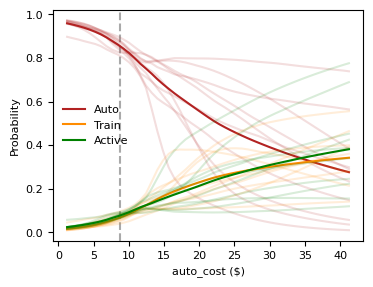

Penalty = 0.0001
------------------------------ 
Test losses and accuracies:
Model 1 : 0.5888, 78.8%
Model 2 : 0.6864, 78.4%
Model 3 : 0.5926, 78.5%
Model 4 : 0.6084, 78.3%
Model 5 : 0.6542, 78.2%
Model 6 : 0.6064, 77.8%
Model 7 : 0.7091, 78.5%
Model 8 : 0.5804, 78.4%
Model 9 : 0.7047, 78.4%
Model 10: 0.6119, 78.6%
------------------------------
Mean test log-likelihood = -1902.9
Mean test accuracy = 78.4%
------------------------------ 
Training set:


,Mode,Share
0,Auto,82.8% (4.6%)
1,Train,9.8% (2.8%)
2,Active,7.5% (1.9%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,65.8% (1.4%)
1,Train,8.3% (0.4%)
2,Active,25.9% (1.1%)


------------------------------
Strong regularity = 0.7136
Weak regularity = 0.8319
------------------------------


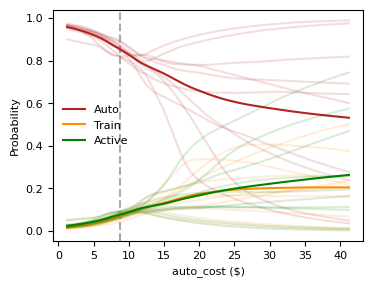

Penalty = 1e-05
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6096, 78.6%
Model 2 : 0.6852, 78.5%
Model 3 : 0.6048, 78.5%
Model 4 : 0.6157, 78.2%
Model 5 : 0.6180, 78.3%
Model 6 : 0.6068, 77.9%
Model 7 : 0.7327, 78.2%
Model 8 : 0.5854, 78.6%
Model 9 : 0.7204, 78.4%
Model 10: 0.6308, 78.7%
------------------------------
Mean test log-likelihood = -1922.8
Mean test accuracy = 78.4%
------------------------------ 
Training set:


,Mode,Share
0,Auto,83.9% (4.7%)
1,Train,8.9% (2.7%)
2,Active,7.3% (2.0%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,65.8% (1.6%)
1,Train,8.3% (0.4%)
2,Active,25.9% (1.2%)


------------------------------
Strong regularity = 0.6163
Weak regularity = 0.7449
------------------------------


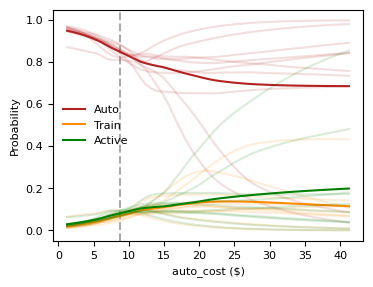

------------------------------ 
Model comparison:


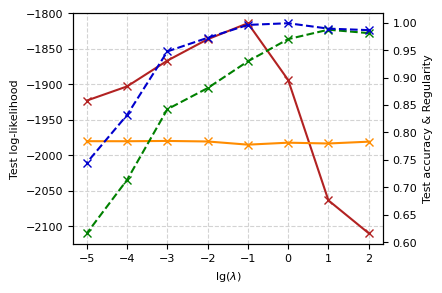

In [ ]:
# With sum
result('util', [np.power(10, i) for i in np.arange(2, -6, -1.0)])

Penalty = 100.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7975, 78.3%
Model 2 : 0.8122, 78.3%
Model 3 : 0.8170, 78.3%
Model 4 : 0.8231, 78.3%
Model 5 : 0.8019, 78.3%
Model 6 : 0.8144, 78.3%
Model 7 : 0.8005, 78.3%
Model 8 : 0.8136, 78.3%
Model 9 : 0.7880, 78.3%
Model 10: 0.7937, 78.3%
------------------------------
Mean test log-likelihood = -2418.6
Mean test accuracy = 78.3%
------------------------------ 
Training set:


,Mode,Share
0,Auto,54.5% (1.4%)
1,Train,20.0% (1.4%)
2,Active,25.5% (0.5%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,54.6% (1.4%)
1,Train,19.9% (1.4%)
2,Active,25.5% (0.5%)


------------------------------
Strong regularity = 0.0578
Weak regularity = 0.9934
------------------------------


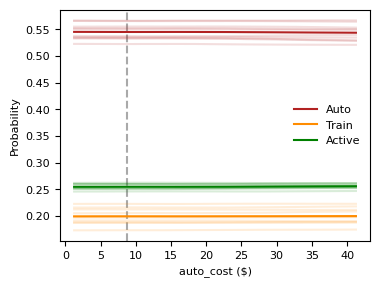

Penalty = 10.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7648, 78.3%
Model 2 : 0.7662, 78.3%
Model 3 : 0.7650, 78.3%
Model 4 : 0.7600, 78.3%
Model 5 : 0.7637, 78.3%
Model 6 : 0.7668, 78.3%
Model 7 : 0.7640, 78.3%
Model 8 : 0.7605, 78.3%
Model 9 : 0.7654, 78.3%
Model 10: 0.7606, 78.3%
------------------------------
Mean test log-likelihood = -2291.1
Mean test accuracy = 78.3%
------------------------------ 
Training set:


,Mode,Share
0,Auto,66.3% (0.2%)
1,Train,9.0% (0.3%)
2,Active,24.6% (0.1%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,66.2% (0.2%)
1,Train,9.1% (0.3%)
2,Active,24.8% (0.1%)


------------------------------
Strong regularity = 0.0410
Weak regularity = 0.8389
------------------------------


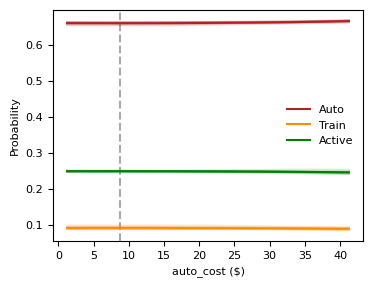

Penalty = 1.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7091, 78.4%
Model 2 : 0.6977, 78.4%
Model 3 : 0.7140, 78.3%
Model 4 : 0.7116, 78.3%
Model 5 : 0.7076, 78.3%
Model 6 : 0.7030, 78.3%
Model 7 : 0.7051, 78.3%
Model 8 : 0.7057, 78.3%
Model 9 : 0.7042, 78.4%
Model 10: 0.7023, 78.3%
------------------------------
Mean test log-likelihood = -2118.1
Mean test accuracy = 78.3%
------------------------------ 
Training set:


,Mode,Share
0,Auto,70.8% (0.8%)
1,Train,8.2% (0.3%)
2,Active,21.0% (0.7%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,66.3% (0.2%)
1,Train,8.6% (0.2%)
2,Active,25.1% (0.2%)


------------------------------
Strong regularity = 0.3314
Weak regularity = 0.5200
------------------------------


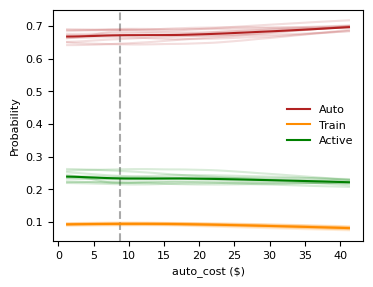

Penalty = 0.1
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6348, 78.5%
Model 2 : 0.6239, 78.6%
Model 3 : 0.6304, 78.5%
Model 4 : 0.6327, 78.4%
Model 5 : 0.6445, 78.5%
Model 6 : 0.6412, 78.4%
Model 7 : 0.6352, 78.6%
Model 8 : 0.6301, 78.7%
Model 9 : 0.6429, 78.5%
Model 10: 0.6326, 78.6%
------------------------------
Mean test log-likelihood = -1904.5
Mean test accuracy = 78.5%
------------------------------ 
Training set:


,Mode,Share
0,Auto,79.5% (1.6%)
1,Train,8.1% (1.1%)
2,Active,12.4% (1.2%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,66.5% (0.5%)
1,Train,8.2% (0.1%)
2,Active,25.3% (0.4%)


------------------------------
Strong regularity = 0.3620
Weak regularity = 0.4883
------------------------------


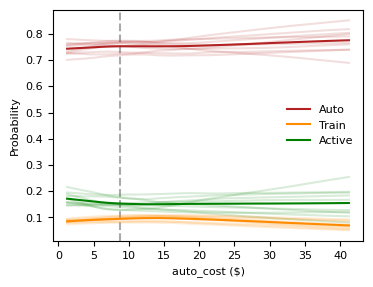

Penalty = 0.01
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6259, 78.3%
Model 2 : 0.5942, 78.4%
Model 3 : 0.6005, 78.4%
Model 4 : 0.5926, 78.4%
Model 5 : 0.6315, 78.5%
Model 6 : 0.6071, 78.5%
Model 7 : 0.6310, 78.4%
Model 8 : 0.6117, 78.4%
Model 9 : 0.6108, 78.4%
Model 10: 0.6275, 78.4%
------------------------------
Mean test log-likelihood = -1839.8
Mean test accuracy = 78.4%
------------------------------ 
Training set:


,Mode,Share
0,Auto,85.4% (1.8%)
1,Train,8.7% (1.4%)
2,Active,5.9% (0.8%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,66.7% (0.8%)
1,Train,8.2% (0.1%)
2,Active,25.0% (0.9%)


------------------------------
Strong regularity = 0.4172
Weak regularity = 0.5273
------------------------------


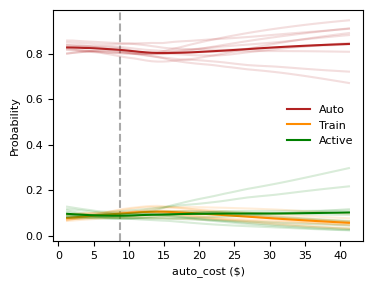

Penalty = 0.001
------------------------------ 
Test losses and accuracies:
Model 1 : 0.5996, 78.5%
Model 2 : 0.6004, 78.6%
Model 3 : 0.5891, 78.5%
Model 4 : 0.5868, 78.5%
Model 5 : 0.6037, 78.5%
Model 6 : 0.5832, 78.4%
Model 7 : 0.6354, 78.4%
Model 8 : 0.6028, 78.4%
Model 9 : 0.5938, 78.4%
Model 10: 0.6135, 78.6%
------------------------------
Mean test log-likelihood = -1802.5
Mean test accuracy = 78.5%
------------------------------ 
Training set:


,Mode,Share
0,Auto,84.1% (2.0%)
1,Train,10.4% (1.3%)
2,Active,5.5% (1.0%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,65.6% (0.7%)
1,Train,8.3% (0.2%)
2,Active,26.1% (0.6%)


------------------------------
Strong regularity = 0.3475
Weak regularity = 0.4544
------------------------------


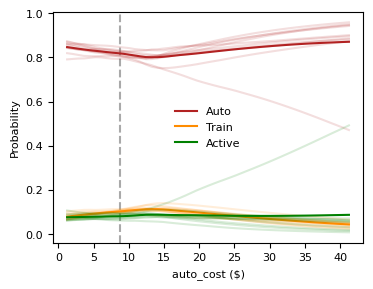

Penalty = 0.0001
------------------------------ 
Test losses and accuracies:
Model 1 : 0.5907, 78.5%
Model 2 : 0.6416, 78.6%
Model 3 : 0.5814, 78.6%
Model 4 : 0.5784, 78.6%
Model 5 : 0.5832, 78.6%
Model 6 : 0.5754, 78.5%
Model 7 : 0.6556, 78.5%
Model 8 : 0.5875, 78.5%
Model 9 : 0.6470, 78.6%
Model 10: 0.6377, 78.5%
------------------------------
Mean test log-likelihood = -1823.5
Mean test accuracy = 78.5%
------------------------------ 
Training set:


,Mode,Share
0,Auto,84.6% (2.8%)
1,Train,9.8% (1.6%)
2,Active,5.5% (1.4%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,65.6% (1.4%)
1,Train,8.4% (0.4%)
2,Active,26.0% (1.2%)


------------------------------
Strong regularity = 0.2421
Weak regularity = 0.3523
------------------------------


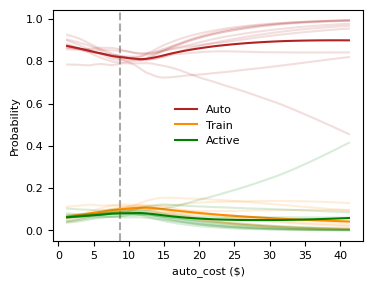

Penalty = 1e-05
------------------------------ 
Test losses and accuracies:
Model 1 : 0.5943, 78.5%
Model 2 : 0.6238, 78.6%
Model 3 : 0.5785, 78.7%
Model 4 : 0.5774, 78.6%
Model 5 : 0.5706, 78.8%
Model 6 : 0.5914, 78.3%
Model 7 : 0.6489, 78.5%
Model 8 : 0.5664, 78.6%
Model 9 : 0.6701, 78.6%
Model 10: 0.6182, 78.7%
------------------------------
Mean test log-likelihood = -1811.9
Mean test accuracy = 78.6%
------------------------------ 
Training set:


,Mode,Share
0,Auto,83.1% (4.7%)
1,Train,9.7% (2.5%)
2,Active,7.2% (2.2%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,65.6% (1.5%)
1,Train,8.4% (0.4%)
2,Active,26.0% (1.1%)


------------------------------
Strong regularity = 0.2715
Weak regularity = 0.3830
------------------------------


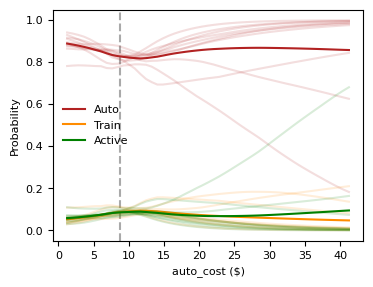

------------------------------ 
Model comparison:


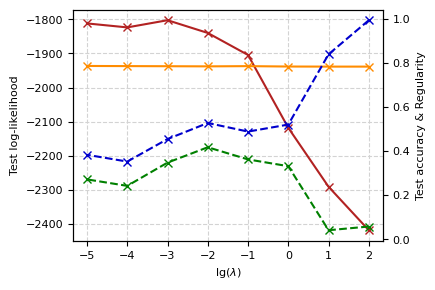

In [ ]:
# With norm
result('util', [np.power(10, i) for i in np.arange(2, -6, -1.0)], False)

### Probability gradient regularization

Penalty = 100.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7197, 78.3%
Model 2 : 0.6834, 78.3%
Model 3 : 0.7437, 78.3%
Model 4 : 0.7354, 78.3%
Model 5 : 0.7357, 78.3%
Model 6 : 0.8660, 78.3%
Model 7 : 0.6927, 78.3%
Model 8 : 0.7137, 78.3%
Model 9 : 0.7066, 78.3%
Model 10: 0.7440, 78.3%
------------------------------
Mean test log-likelihood = -2202.3
Mean test accuracy = 78.3%
------------------------------ 
Training set:


,Mode,Share
0,Auto,64.9% (6.6%)
1,Train,12.6% (4.6%)
2,Active,22.6% (2.6%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,63.1% (4.9%)
1,Train,13.3% (3.9%)
2,Active,23.5% (2.3%)


------------------------------
Strong regularity = 0.9550
Weak regularity = 0.9644
------------------------------


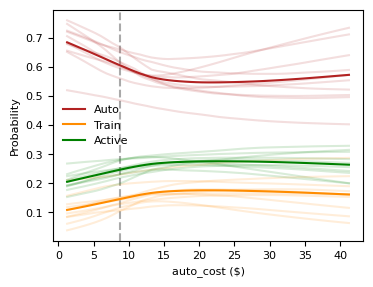

Penalty = 10.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6784, 77.6%
Model 2 : 0.6751, 74.8%
Model 3 : 0.6883, 77.5%
Model 4 : 0.6768, 77.6%
Model 5 : 0.6648, 77.2%
Model 6 : 0.7194, 78.3%
Model 7 : 0.6797, 76.7%
Model 8 : 0.6858, 77.1%
Model 9 : 0.6666, 78.0%
Model 10: 0.6641, 78.3%
------------------------------
Mean test log-likelihood = -2039.7
Mean test accuracy = 77.3%
------------------------------ 
Training set:


,Mode,Share
0,Auto,71.5% (3.4%)
1,Train,8.2% (0.9%)
2,Active,20.3% (2.7%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,67.0% (0.8%)
1,Train,8.4% (0.2%)
2,Active,24.6% (0.8%)


------------------------------
Strong regularity = 0.9913
Weak regularity = 0.9939
------------------------------


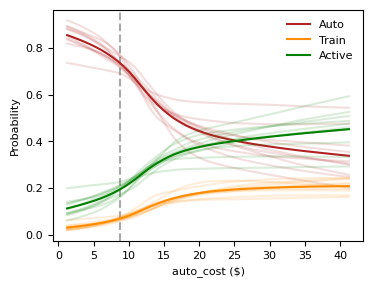

Penalty = 1.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6473, 78.2%
Model 2 : 0.6077, 77.1%
Model 3 : 0.6063, 78.0%
Model 4 : 0.6487, 78.3%
Model 5 : 0.6292, 78.2%
Model 6 : 0.6220, 76.2%
Model 7 : 0.6890, 77.6%
Model 8 : 0.5808, 78.4%
Model 9 : 0.6335, 78.0%
Model 10: 0.6280, 77.4%
------------------------------
Mean test log-likelihood = -1887.8
Mean test accuracy = 77.7%
------------------------------ 
Training set:


,Mode,Share
0,Auto,79.8% (3.5%)
1,Train,13.0% (2.8%)
2,Active,7.3% (1.6%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,66.9% (1.0%)
1,Train,8.3% (0.4%)
2,Active,24.9% (0.8%)


------------------------------
Strong regularity = 0.9292
Weak regularity = 0.9999
------------------------------


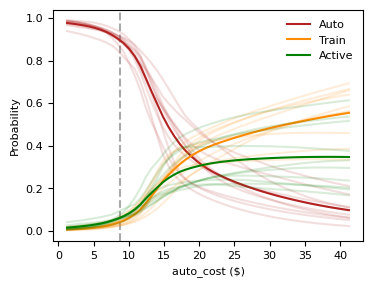

Penalty = 0.1
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6099, 78.0%
Model 2 : 0.6343, 78.6%
Model 3 : 0.5945, 78.3%
Model 4 : 0.6435, 78.4%
Model 5 : 0.6382, 78.6%
Model 6 : 0.6296, 76.1%
Model 7 : 0.6748, 78.2%
Model 8 : 0.5878, 77.9%
Model 9 : 0.6541, 78.4%
Model 10: 0.6038, 78.4%
------------------------------
Mean test log-likelihood = -1881.2
Mean test accuracy = 78.1%
------------------------------ 
Training set:


,Mode,Share
0,Auto,80.2% (3.6%)
1,Train,12.3% (2.1%)
2,Active,7.5% (1.6%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,65.7% (1.3%)
1,Train,8.6% (0.3%)
2,Active,25.7% (1.1%)


------------------------------
Strong regularity = 0.9141
Weak regularity = 0.9978
------------------------------


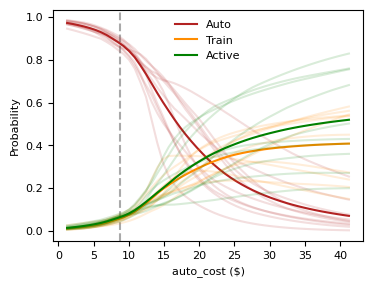

Penalty = 0.01
------------------------------ 
Test losses and accuracies:
Model 1 : 0.5917, 78.3%
Model 2 : 0.6743, 78.6%
Model 3 : 0.6085, 78.3%
Model 4 : 0.6261, 78.4%
Model 5 : 0.6890, 78.4%
Model 6 : 0.6195, 77.8%
Model 7 : 0.7022, 78.4%
Model 8 : 0.5939, 78.4%
Model 9 : 0.6693, 78.7%
Model 10: 0.6155, 78.4%
------------------------------
Mean test log-likelihood = -1917.0
Mean test accuracy = 78.4%
------------------------------ 
Training set:


,Mode,Share
0,Auto,81.9% (3.1%)
1,Train,10.8% (2.0%)
2,Active,7.3% (1.2%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,65.3% (1.5%)
1,Train,8.6% (0.4%)
2,Active,26.1% (1.2%)


------------------------------
Strong regularity = 0.8703
Weak regularity = 0.9764
------------------------------


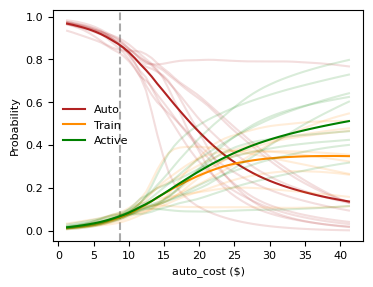

Penalty = 0.001
------------------------------ 
Test losses and accuracies:
Model 1 : 0.5929, 78.6%
Model 2 : 0.6692, 78.8%
Model 3 : 0.6205, 78.7%
Model 4 : 0.6323, 78.2%
Model 5 : 0.6630, 78.3%
Model 6 : 0.5997, 77.7%
Model 7 : 0.7080, 78.2%
Model 8 : 0.5931, 78.5%
Model 9 : 0.6900, 78.4%
Model 10: 0.6188, 78.6%
------------------------------
Mean test log-likelihood = -1916.2
Mean test accuracy = 78.4%
------------------------------ 
Training set:


,Mode,Share
0,Auto,83.1% (3.5%)
1,Train,9.9% (2.2%)
2,Active,7.0% (1.4%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,65.7% (1.5%)
1,Train,8.4% (0.3%)
2,Active,25.8% (1.2%)


------------------------------
Strong regularity = 0.8103
Weak regularity = 0.9229
------------------------------


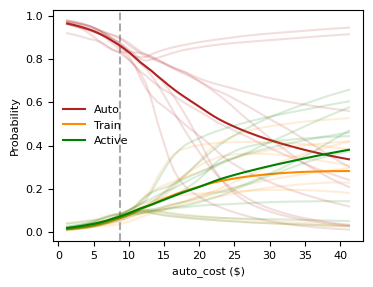

Penalty = 0.0001
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6106, 78.7%
Model 2 : 0.6985, 78.5%
Model 3 : 0.6052, 78.5%
Model 4 : 0.6117, 78.2%
Model 5 : 0.6263, 78.3%
Model 6 : 0.5992, 77.9%
Model 7 : 0.7153, 78.2%
Model 8 : 0.5937, 78.4%
Model 9 : 0.6924, 78.4%
Model 10: 0.6377, 78.5%
------------------------------
Mean test log-likelihood = -1917.1
Mean test accuracy = 78.4%
------------------------------ 
Training set:


,Mode,Share
0,Auto,83.8% (4.0%)
1,Train,9.0% (2.3%)
2,Active,7.2% (1.8%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,65.8% (1.6%)
1,Train,8.4% (0.4%)
2,Active,25.8% (1.2%)


------------------------------
Strong regularity = 0.6807
Weak regularity = 0.8063
------------------------------


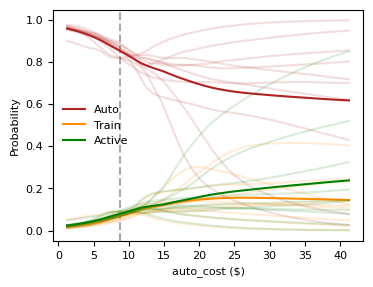

Penalty = 1e-05
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6318, 78.6%
Model 2 : 0.6822, 78.5%
Model 3 : 0.6169, 78.5%
Model 4 : 0.6154, 78.2%
Model 5 : 0.6210, 78.3%
Model 6 : 0.6066, 77.7%
Model 7 : 0.7262, 78.3%
Model 8 : 0.5855, 78.6%
Model 9 : 0.7045, 78.5%
Model 10: 0.6674, 78.7%
------------------------------
Mean test log-likelihood = -1937.3
Mean test accuracy = 78.4%
------------------------------ 
Training set:


,Mode,Share
0,Auto,84.3% (4.8%)
1,Train,8.5% (2.7%)
2,Active,7.2% (2.2%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,65.8% (1.5%)
1,Train,8.3% (0.4%)
2,Active,25.8% (1.2%)


------------------------------
Strong regularity = 0.5639
Weak regularity = 0.7002
------------------------------


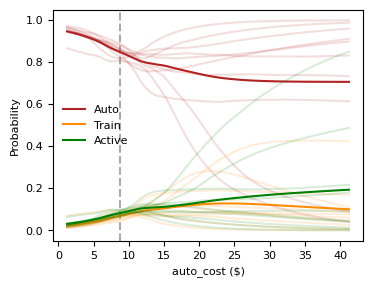

------------------------------ 
Model comparison:


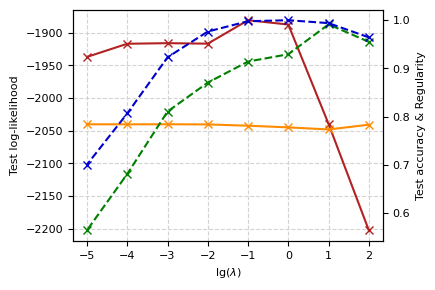

In [ ]:
# With sum
result('prob', [np.power(10, i) for i in np.arange(2, -6, -1.0)])

Penalty = 1000.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.8568, 78.3%
Model 2 : 0.8262, 78.3%
Model 3 : 0.8778, 78.3%
Model 4 : 0.8541, 78.3%
Model 5 : 0.8252, 78.3%
Model 6 : 0.9267, 78.3%
Model 7 : 0.8245, 78.3%
Model 8 : 0.8469, 78.3%
Model 9 : 0.7923, 78.3%
Model 10: 0.7905, 78.3%
------------------------------
Mean test log-likelihood = -2526.3
Mean test accuracy = 78.3%
------------------------------ 
Training set:


,Mode,Share
0,Auto,51.3% (3.7%)
1,Train,21.4% (2.4%)
2,Active,27.3% (1.5%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,51.3% (3.7%)
1,Train,21.4% (2.4%)
2,Active,27.3% (1.5%)


------------------------------
Strong regularity = 0.0255
Weak regularity = 0.9923
------------------------------


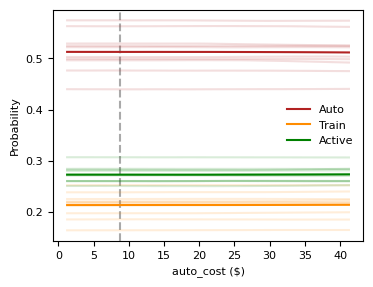

Penalty = 100.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7703, 78.3%
Model 2 : 0.7696, 78.3%
Model 3 : 0.7700, 78.3%
Model 4 : 0.7756, 78.3%
Model 5 : 0.7704, 78.3%
Model 6 : 0.7747, 78.3%
Model 7 : 0.7721, 78.3%
Model 8 : 0.7719, 78.3%
Model 9 : 0.7703, 78.3%
Model 10: 0.7735, 78.3%
------------------------------
Mean test log-likelihood = -2315.5
Mean test accuracy = 78.3%
------------------------------ 
Training set:


,Mode,Share
0,Auto,66.7% (0.2%)
1,Train,8.1% (0.1%)
2,Active,25.2% (0.2%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,66.5% (0.2%)
1,Train,8.2% (0.1%)
2,Active,25.3% (0.2%)


------------------------------
Strong regularity = 0.0444
Weak regularity = 0.7853
------------------------------


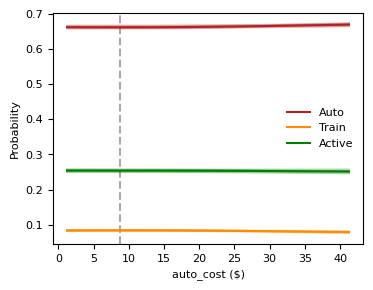

Penalty = 10.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7146, 78.5%
Model 2 : 0.7068, 78.3%
Model 3 : 0.7134, 78.3%
Model 4 : 0.7107, 78.3%
Model 5 : 0.7144, 78.3%
Model 6 : 0.7188, 78.3%
Model 7 : 0.7103, 78.3%
Model 8 : 0.7009, 78.3%
Model 9 : 0.7068, 78.3%
Model 10: 0.7106, 78.3%
------------------------------
Mean test log-likelihood = -2132.2
Mean test accuracy = 78.3%
------------------------------ 
Training set:


,Mode,Share
0,Auto,71.2% (0.7%)
1,Train,7.8% (0.3%)
2,Active,21.0% (0.5%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,67.7% (0.2%)
1,Train,7.8% (0.2%)
2,Active,24.5% (0.3%)


------------------------------
Strong regularity = 0.2412
Weak regularity = 0.4818
------------------------------


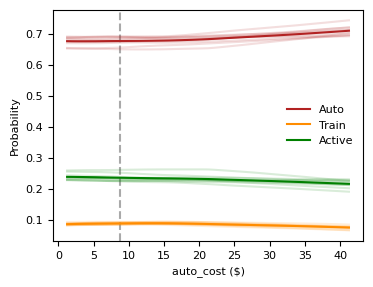

Penalty = 1.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6635, 78.6%
Model 2 : 0.6403, 78.5%
Model 3 : 0.6453, 78.5%
Model 4 : 0.6517, 78.5%
Model 5 : 0.6411, 78.4%
Model 6 : 0.6573, 78.5%
Model 7 : 0.6390, 78.5%
Model 8 : 0.6471, 78.6%
Model 9 : 0.6551, 78.5%
Model 10: 0.6437, 78.4%
------------------------------
Mean test log-likelihood = -1945.3
Mean test accuracy = 78.5%
------------------------------ 
Training set:


,Mode,Share
0,Auto,75.5% (1.3%)
1,Train,8.8% (0.7%)
2,Active,15.6% (1.0%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,67.2% (0.4%)
1,Train,7.6% (0.2%)
2,Active,25.1% (0.4%)


------------------------------
Strong regularity = 0.2910
Weak regularity = 0.3946
------------------------------


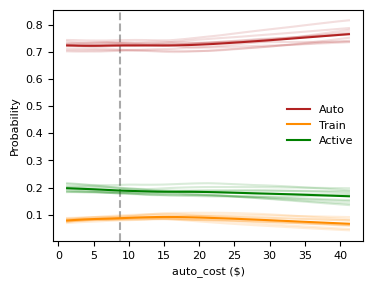

Penalty = 0.1
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6146, 78.6%
Model 2 : 0.6110, 78.6%
Model 3 : 0.6135, 78.6%
Model 4 : 0.6184, 78.6%
Model 5 : 0.6122, 78.5%
Model 6 : 0.6262, 78.5%
Model 7 : 0.6151, 78.6%
Model 8 : 0.6147, 78.6%
Model 9 : 0.6196, 78.6%
Model 10: 0.6109, 78.5%
------------------------------
Mean test log-likelihood = -1846.8
Mean test accuracy = 78.6%
------------------------------ 
Training set:


,Mode,Share
0,Auto,80.8% (1.2%)
1,Train,9.1% (0.7%)
2,Active,10.1% (1.0%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,67.1% (0.9%)
1,Train,7.5% (0.3%)
2,Active,25.4% (0.7%)


------------------------------
Strong regularity = 0.3057
Weak regularity = 0.3734
------------------------------


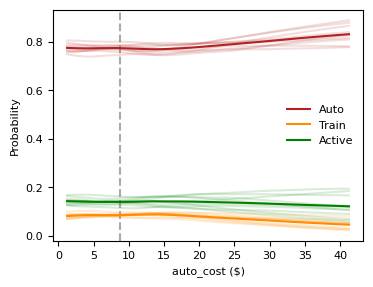

Penalty = 0.01
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6047, 78.6%
Model 2 : 0.6271, 78.5%
Model 3 : 0.6047, 78.6%
Model 4 : 0.6138, 78.5%
Model 5 : 0.6036, 78.6%
Model 6 : 0.6055, 78.5%
Model 7 : 0.6073, 78.5%
Model 8 : 0.6079, 78.5%
Model 9 : 0.6331, 78.5%
Model 10: 0.6160, 78.5%
------------------------------
Mean test log-likelihood = -1837.1
Mean test accuracy = 78.5%
------------------------------ 
Training set:


,Mode,Share
0,Auto,83.4% (1.7%)
1,Train,10.2% (1.6%)
2,Active,6.4% (0.6%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,66.4% (1.1%)
1,Train,7.5% (0.3%)
2,Active,26.1% (0.9%)


------------------------------
Strong regularity = 0.2508
Weak regularity = 0.3093
------------------------------


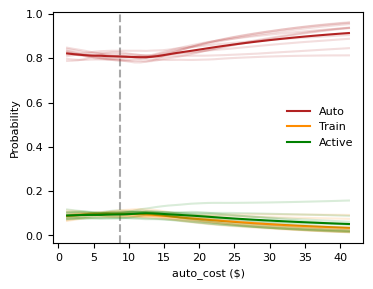

Penalty = 0.001
------------------------------ 
Test losses and accuracies:
Model 1 : 0.5791, 78.5%
Model 2 : 0.6101, 78.4%
Model 3 : 0.5787, 78.5%
Model 4 : 0.5894, 78.5%
Model 5 : 0.5719, 78.6%
Model 6 : 0.5850, 78.5%
Model 7 : 0.6236, 78.4%
Model 8 : 0.5765, 78.5%
Model 9 : 0.6376, 78.4%
Model 10: 0.6141, 78.4%
------------------------------
Mean test log-likelihood = -1789.8
Mean test accuracy = 78.5%
------------------------------ 
Training set:


,Mode,Share
0,Auto,83.5% (2.8%)
1,Train,10.0% (1.7%)
2,Active,6.5% (1.3%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,66.3% (1.3%)
1,Train,7.6% (0.3%)
2,Active,26.1% (1.0%)


------------------------------
Strong regularity = 0.2025
Weak regularity = 0.2918
------------------------------


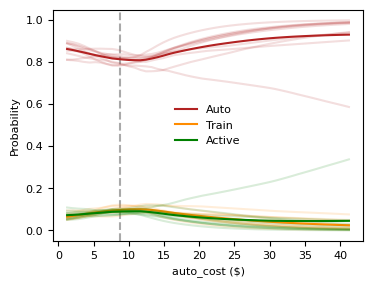

Penalty = 0.0001
------------------------------ 
Test losses and accuracies:
Model 1 : 0.5842, 78.5%
Model 2 : 0.6377, 78.4%
Model 3 : 0.5655, 78.8%
Model 4 : 0.5791, 78.6%
Model 5 : 0.5656, 78.9%
Model 6 : 0.6003, 78.4%
Model 7 : 0.6325, 78.5%
Model 8 : 0.5667, 78.5%
Model 9 : 0.6587, 78.5%
Model 10: 0.6085, 78.6%
------------------------------
Mean test log-likelihood = -1799.6
Mean test accuracy = 78.6%
------------------------------ 
Training set:


,Mode,Share
0,Auto,82.5% (4.8%)
1,Train,9.6% (2.5%)
2,Active,7.8% (2.4%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,66.1% (1.4%)
1,Train,7.9% (0.4%)
2,Active,26.0% (1.1%)


------------------------------
Strong regularity = 0.2848
Weak regularity = 0.3937
------------------------------


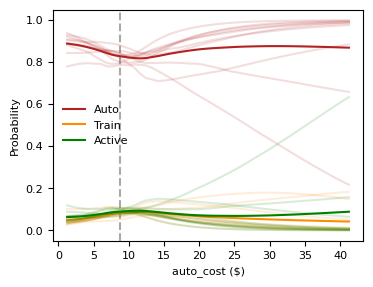

------------------------------ 
Model comparison:


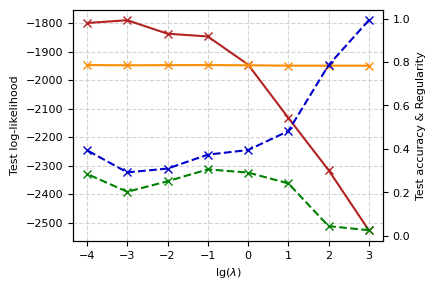

In [ ]:
# With norm
result('prob', [np.power(10, i) for i in np.arange(3, -5, -1.0)], False)

### Loss gradient regularization

Penalty = 100.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7693, 78.3%
Model 2 : 0.7584, 78.3%
Model 3 : 0.8721, 78.3%
Model 4 : 0.7816, 78.3%
Model 5 : 0.8205, 78.3%
Model 6 : 0.9698, 78.3%
Model 7 : 0.7004, 78.3%
Model 8 : 0.8465, 78.3%
Model 9 : 0.7599, 78.3%
Model 10: 0.8352, 78.3%
------------------------------
Mean test log-likelihood = -2434.1
Mean test accuracy = 78.3%
------------------------------ 
Training set:


,Mode,Share
0,Auto,53.1% (6.5%)
1,Train,21.4% (4.7%)
2,Active,25.5% (3.7%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,51.9% (5.6%)
1,Train,21.7% (4.4%)
2,Active,26.4% (2.9%)


------------------------------
Strong regularity = 0.8884
Weak regularity = 0.9116
------------------------------


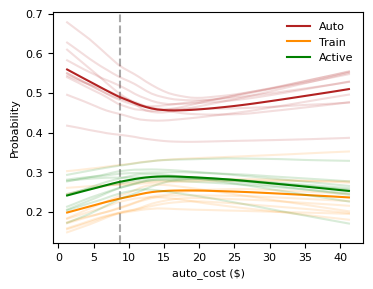

Penalty = 10.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6942, 78.3%
Model 2 : 0.6450, 78.1%
Model 3 : 0.7114, 78.5%
Model 4 : 0.6885, 78.3%
Model 5 : 0.7012, 78.4%
Model 6 : 0.7160, 78.3%
Model 7 : 0.6828, 76.6%
Model 8 : 0.6948, 78.4%
Model 9 : 0.6684, 77.9%
Model 10: 0.7001, 78.4%
------------------------------
Mean test log-likelihood = -2070.7
Mean test accuracy = 78.1%
------------------------------ 
Training set:


,Mode,Share
0,Auto,73.5% (3.0%)
1,Train,7.3% (0.9%)
2,Active,19.2% (2.4%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,67.4% (0.8%)
1,Train,8.5% (0.3%)
2,Active,24.1% (0.8%)


------------------------------
Strong regularity = 0.9844
Weak regularity = 0.9889
------------------------------


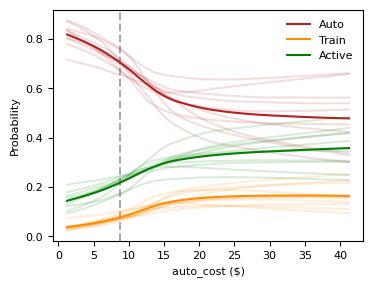

Penalty = 1.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6121, 78.2%
Model 2 : 0.6307, 78.4%
Model 3 : 0.6333, 78.3%
Model 4 : 0.6464, 78.1%
Model 5 : 0.6193, 78.3%
Model 6 : 0.6320, 78.1%
Model 7 : 0.7268, 78.2%
Model 8 : 0.6216, 79.0%
Model 9 : 0.6229, 77.7%
Model 10: 0.6950, 78.6%
------------------------------
Mean test log-likelihood = -1932.0
Mean test accuracy = 78.3%
------------------------------ 
Training set:


,Mode,Share
0,Auto,80.5% (4.1%)
1,Train,10.2% (2.0%)
2,Active,9.3% (2.9%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,66.7% (1.2%)
1,Train,8.6% (1.0%)
2,Active,24.7% (1.4%)


------------------------------
Strong regularity = 0.9309
Weak regularity = 0.9979
------------------------------


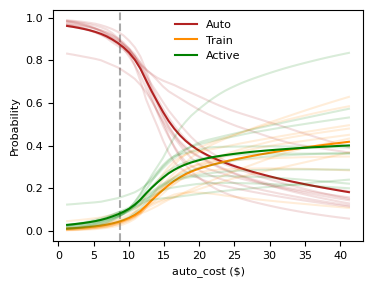

Penalty = 0.1
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6239, 78.6%
Model 2 : 0.6401, 78.4%
Model 3 : 0.6526, 78.6%
Model 4 : 0.6186, 78.2%
Model 5 : 0.6220, 78.6%
Model 6 : 0.6233, 75.9%
Model 7 : 0.7107, 78.3%
Model 8 : 0.5894, 78.2%
Model 9 : 0.6509, 78.3%
Model 10: 0.6135, 78.4%
------------------------------
Mean test log-likelihood = -1903.5
Mean test accuracy = 78.2%
------------------------------ 
Training set:


,Mode,Share
0,Auto,81.1% (3.8%)
1,Train,11.9% (2.4%)
2,Active,7.0% (1.5%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,66.0% (1.2%)
1,Train,8.5% (0.3%)
2,Active,25.6% (1.2%)


------------------------------
Strong regularity = 0.9098
Weak regularity = 0.9964
------------------------------


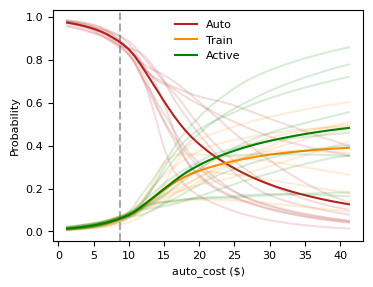

Penalty = 0.01
------------------------------ 
Test losses and accuracies:
Model 1 : 0.5878, 78.5%
Model 2 : 0.6527, 78.6%
Model 3 : 0.6076, 78.2%
Model 4 : 0.6411, 78.2%
Model 5 : 0.6850, 78.4%
Model 6 : 0.6170, 77.2%
Model 7 : 0.7216, 78.6%
Model 8 : 0.5925, 78.4%
Model 9 : 0.6418, 78.6%
Model 10: 0.6071, 78.6%
------------------------------
Mean test log-likelihood = -1906.3
Mean test accuracy = 78.3%
------------------------------ 
Training set:


,Mode,Share
0,Auto,81.6% (3.5%)
1,Train,11.0% (2.2%)
2,Active,7.3% (1.5%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,65.3% (1.5%)
1,Train,8.6% (0.4%)
2,Active,26.2% (1.3%)


------------------------------
Strong regularity = 0.8768
Weak regularity = 0.9775
------------------------------


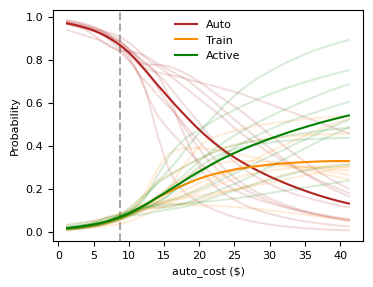

Penalty = 0.001
------------------------------ 
Test losses and accuracies:
Model 1 : 0.5993, 78.5%
Model 2 : 0.7178, 78.4%
Model 3 : 0.6176, 78.4%
Model 4 : 0.6498, 78.3%
Model 5 : 0.6426, 78.3%
Model 6 : 0.6123, 77.4%
Model 7 : 0.7111, 78.3%
Model 8 : 0.5855, 78.4%
Model 9 : 0.6963, 78.4%
Model 10: 0.6089, 78.5%
------------------------------
Mean test log-likelihood = -1932.4
Mean test accuracy = 78.3%
------------------------------ 
Training set:


,Mode,Share
0,Auto,82.7% (4.3%)
1,Train,10.0% (2.6%)
2,Active,7.3% (1.7%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,65.7% (1.4%)
1,Train,8.4% (0.3%)
2,Active,25.9% (1.1%)


------------------------------
Strong regularity = 0.8169
Weak regularity = 0.9290
------------------------------


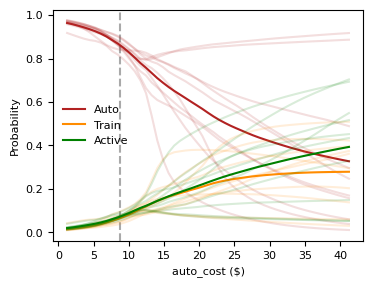

Penalty = 0.0001
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6110, 78.7%
Model 2 : 0.6854, 78.5%
Model 3 : 0.6132, 78.5%
Model 4 : 0.6213, 78.1%
Model 5 : 0.6299, 78.3%
Model 6 : 0.5976, 78.0%
Model 7 : 0.7129, 78.2%
Model 8 : 0.5833, 78.5%
Model 9 : 0.7110, 78.4%
Model 10: 0.6590, 78.5%
------------------------------
Mean test log-likelihood = -1927.4
Mean test accuracy = 78.4%
------------------------------ 
Training set:


,Mode,Share
0,Auto,83.9% (4.2%)
1,Train,8.9% (2.5%)
2,Active,7.2% (1.8%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,65.7% (1.6%)
1,Train,8.4% (0.4%)
2,Active,26.0% (1.2%)


------------------------------
Strong regularity = 0.6900
Weak regularity = 0.8168
------------------------------


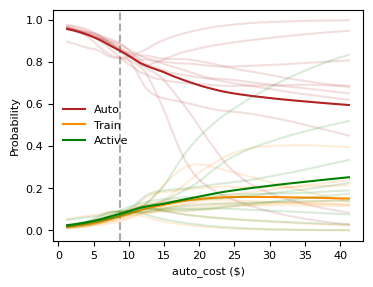

Penalty = 1e-05
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6360, 78.6%
Model 2 : 0.7142, 78.4%
Model 3 : 0.6162, 78.5%
Model 4 : 0.6140, 78.2%
Model 5 : 0.6238, 78.3%
Model 6 : 0.6066, 77.8%
Model 7 : 0.7109, 78.3%
Model 8 : 0.5836, 78.5%
Model 9 : 0.6994, 78.4%
Model 10: 0.6592, 78.7%
------------------------------
Mean test log-likelihood = -1939.2
Mean test accuracy = 78.4%
------------------------------ 
Training set:


,Mode,Share
0,Auto,84.3% (4.9%)
1,Train,8.6% (2.8%)
2,Active,7.2% (2.2%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,65.8% (1.5%)
1,Train,8.3% (0.4%)
2,Active,25.9% (1.2%)


------------------------------
Strong regularity = 0.5745
Weak regularity = 0.7066
------------------------------


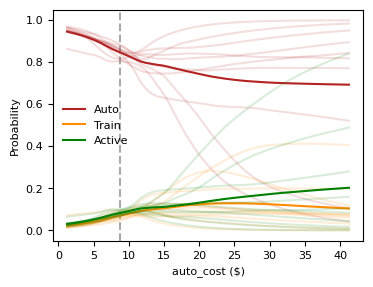

------------------------------ 
Model comparison:


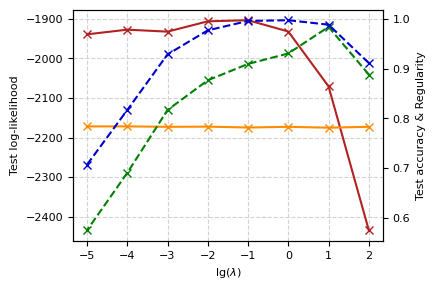

In [ ]:
# With sum
result('loss', [np.power(10, i) for i in np.arange(2, -6, -1.0)])

Penalty = 1000.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.9738, 78.3%
Model 2 : 0.9823, 78.3%
Model 3 : 0.9811, 78.3%
Model 4 : 0.9962, 78.3%
Model 5 : 1.0007, 78.3%
Model 6 : 1.0147, 78.3%
Model 7 : 0.9949, 78.3%
Model 8 : 1.0150, 78.3%
Model 9 : 0.9225, 78.3%
Model 10: 0.9550, 78.3%
------------------------------
Mean test log-likelihood = -2950.9
Mean test accuracy = 78.3%
------------------------------ 
Training set:


,Mode,Share
0,Auto,39.9% (1.8%)
1,Train,28.9% (1.8%)
2,Active,31.2% (1.0%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,40.0% (1.8%)
1,Train,28.9% (1.8%)
2,Active,31.2% (1.0%)


------------------------------
Strong regularity = 0.0468
Weak regularity = 0.9856
------------------------------


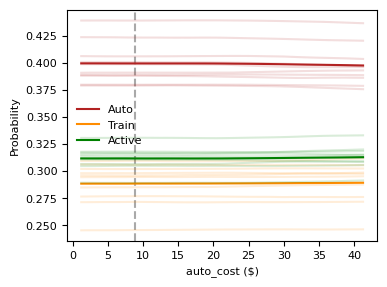

Penalty = 100.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7546, 78.3%
Model 2 : 0.7493, 78.3%
Model 3 : 0.7715, 78.3%
Model 4 : 0.7807, 78.3%
Model 5 : 0.7553, 78.3%
Model 6 : 0.8183, 78.3%
Model 7 : 0.7496, 78.3%
Model 8 : 0.7597, 78.3%
Model 9 : 0.7545, 78.3%
Model 10: 0.7609, 78.3%
------------------------------
Mean test log-likelihood = -2296.2
Mean test accuracy = 78.3%
------------------------------ 
Training set:


,Mode,Share
0,Auto,63.0% (3.8%)
1,Train,12.5% (2.7%)
2,Active,24.5% (1.2%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,63.0% (3.8%)
1,Train,12.5% (2.7%)
2,Active,24.5% (1.2%)


------------------------------
Strong regularity = 0.0455
Weak regularity = 0.9189
------------------------------


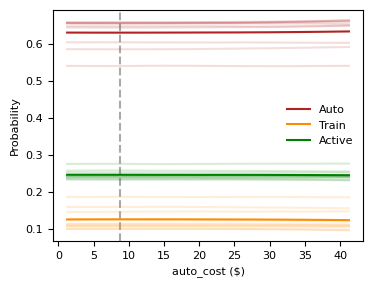

Penalty = 10.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7524, 78.3%
Model 2 : 0.7447, 78.3%
Model 3 : 0.7487, 78.3%
Model 4 : 0.7492, 78.3%
Model 5 : 0.7455, 78.3%
Model 6 : 0.7602, 78.3%
Model 7 : 0.7452, 78.3%
Model 8 : 0.7482, 78.3%
Model 9 : 0.7446, 78.3%
Model 10: 0.7486, 78.3%
------------------------------
Mean test log-likelihood = -2246.2
Mean test accuracy = 78.3%
------------------------------ 
Training set:


,Mode,Share
0,Auto,67.6% (0.3%)
1,Train,8.6% (0.2%)
2,Active,23.8% (0.3%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,66.6% (0.2%)
1,Train,8.8% (0.2%)
2,Active,24.6% (0.2%)


------------------------------
Strong regularity = 0.1161
Weak regularity = 0.4756
------------------------------


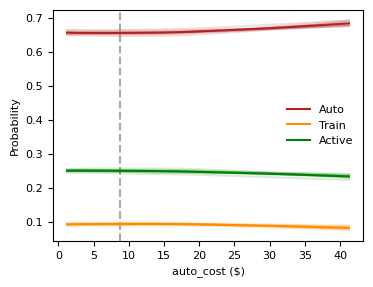

Penalty = 1.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7011, 78.4%
Model 2 : 0.6736, 78.4%
Model 3 : 0.6862, 78.4%
Model 4 : 0.6884, 78.4%
Model 5 : 0.6872, 78.4%
Model 6 : 0.6925, 78.4%
Model 7 : 0.6843, 78.5%
Model 8 : 0.6761, 78.6%
Model 9 : 0.6893, 78.4%
Model 10: 0.6762, 78.4%
------------------------------
Mean test log-likelihood = -2056.5
Mean test accuracy = 78.4%
------------------------------ 
Training set:


,Mode,Share
0,Auto,71.7% (0.9%)
1,Train,8.8% (0.5%)
2,Active,19.5% (0.8%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,66.6% (0.3%)
1,Train,8.4% (0.2%)
2,Active,24.9% (0.2%)


------------------------------
Strong regularity = 0.3199
Weak regularity = 0.4432
------------------------------


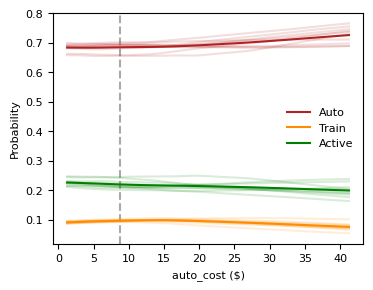

Penalty = 0.1
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6373, 78.4%
Model 2 : 0.6222, 78.4%
Model 3 : 0.6333, 78.5%
Model 4 : 0.6341, 78.5%
Model 5 : 0.6263, 78.4%
Model 6 : 0.6393, 78.5%
Model 7 : 0.6223, 78.6%
Model 8 : 0.6267, 78.5%
Model 9 : 0.6375, 78.5%
Model 10: 0.6263, 78.5%
------------------------------
Mean test log-likelihood = -1891.6
Mean test accuracy = 78.5%
------------------------------ 
Training set:


,Mode,Share
0,Auto,76.1% (1.1%)
1,Train,10.4% (0.6%)
2,Active,13.5% (0.9%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,66.9% (0.5%)
1,Train,8.2% (0.3%)
2,Active,24.9% (0.4%)


------------------------------
Strong regularity = 0.2815
Weak regularity = 0.3412
------------------------------


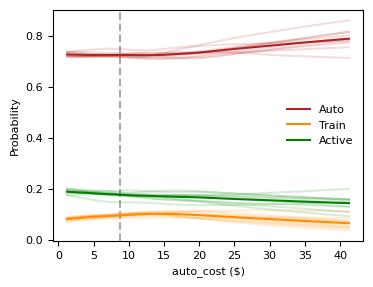

Penalty = 0.01
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6097, 78.6%
Model 2 : 0.6063, 78.5%
Model 3 : 0.6085, 78.6%
Model 4 : 0.6166, 78.4%
Model 5 : 0.6036, 78.6%
Model 6 : 0.6113, 78.6%
Model 7 : 0.6077, 78.6%
Model 8 : 0.6038, 78.5%
Model 9 : 0.6172, 78.4%
Model 10: 0.6111, 78.6%
------------------------------
Mean test log-likelihood = -1828.8
Mean test accuracy = 78.5%
------------------------------ 
Training set:


,Mode,Share
0,Auto,80.2% (1.7%)
1,Train,11.7% (1.1%)
2,Active,8.1% (1.0%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,66.7% (1.0%)
1,Train,8.2% (0.2%)
2,Active,25.2% (0.9%)


------------------------------
Strong regularity = 0.2558
Weak regularity = 0.2956
------------------------------


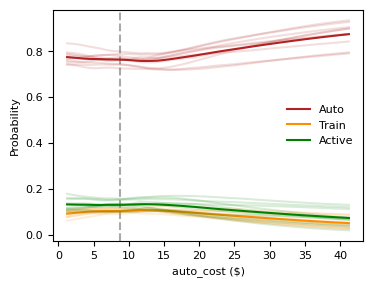

Penalty = 0.001
------------------------------ 
Test losses and accuracies:
Model 1 : 0.5986, 78.5%
Model 2 : 0.6066, 78.4%
Model 3 : 0.5966, 78.5%
Model 4 : 0.5905, 78.5%
Model 5 : 0.5850, 78.6%
Model 6 : 0.6039, 78.6%
Model 7 : 0.6123, 78.5%
Model 8 : 0.5933, 78.5%
Model 9 : 0.6214, 78.5%
Model 10: 0.6151, 78.5%
------------------------------
Mean test log-likelihood = -1807.0
Mean test accuracy = 78.5%
------------------------------ 
Training set:


,Mode,Share
0,Auto,80.1% (2.2%)
1,Train,13.4% (1.3%)
2,Active,6.5% (1.1%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,65.6% (1.4%)
1,Train,8.3% (0.4%)
2,Active,26.1% (1.1%)


------------------------------
Strong regularity = 0.1938
Weak regularity = 0.2362
------------------------------


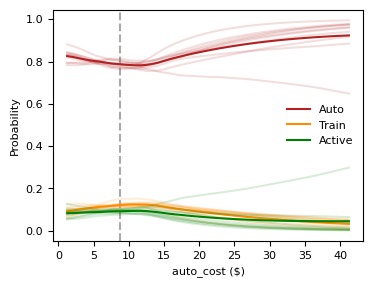

Penalty = 0.0001
------------------------------ 
Test losses and accuracies:
Model 1 : 0.5785, 78.5%
Model 2 : 0.5792, 78.5%
Model 3 : 0.5804, 78.6%
Model 4 : 0.5864, 78.6%
Model 5 : 0.5661, 78.9%
Model 6 : 0.6072, 78.5%
Model 7 : 0.5956, 78.5%
Model 8 : 0.5719, 78.4%
Model 9 : 0.6062, 78.6%
Model 10: 0.5975, 78.5%
------------------------------
Mean test log-likelihood = -1760.8
Mean test accuracy = 78.6%
------------------------------ 
Training set:


,Mode,Share
0,Auto,78.6% (4.0%)
1,Train,13.4% (2.1%)
2,Active,8.0% (2.0%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,65.5% (1.5%)
1,Train,8.3% (0.3%)
2,Active,26.2% (1.2%)


------------------------------
Strong regularity = 0.2698
Weak regularity = 0.3449
------------------------------


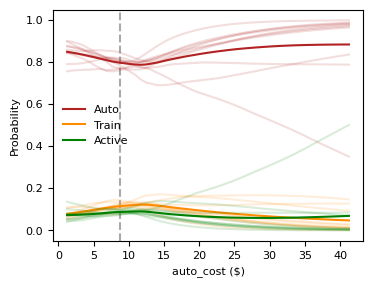

------------------------------ 
Model comparison:


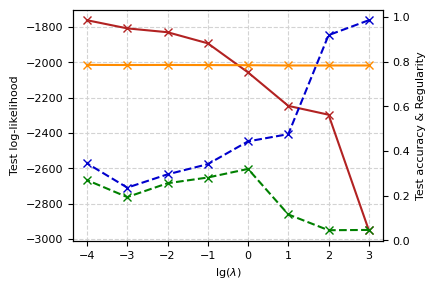

In [ ]:
# With norm
result('loss', [np.power(10, i) for i in np.arange(3, -5, -1.0)], False)